In [641]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import norm

In [642]:
data = pd.read_csv("d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\Q01_HL_23.csv", skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "Prietok"],
                  sep = ";", decimal=',')

In [643]:
rain = pd.read_csv("d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\SR02_H2_27374.csv", skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

In [644]:
data["date"] = pd.to_datetime(data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

In [645]:
rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

In [646]:
rain["date"] = rain.index

In [647]:
print(rain['date'].diff().dropna().min())
print(rain['date'].diff().dropna().max())
print(rain['date'].diff().dropna().value_counts())

0 days 00:01:00
0 days 00:10:00
0 days 00:10:00    4155
0 days 00:01:00    2496
0 days 00:04:00      20
0 days 00:07:00      16
0 days 00:06:00      16
0 days 00:02:00      14
0 days 00:09:00      14
0 days 00:03:00      13
0 days 00:08:00       9
0 days 00:05:00       8
Name: date, dtype: int64


In [648]:
print(data['date'].diff().dropna().min())
print(data['date'].diff().dropna().max())
print(data['date'].diff().dropna().value_counts())

0 days 00:02:00
0 days 00:04:00
0 days 00:02:00    22317
0 days 00:04:00        1
Name: date, dtype: int64


In [649]:
sum(data['date'].dt.minute % 2 != 0)

0

In [650]:
rain.index = range(rain.shape[0])

In [651]:
rain.head(10)

,rain,rain_2m,date
0,0.0,NaN,2022-05-31 23:01:00
1,0.1,0.1,2022-05-31 23:02:00
2,0.0,NaN,2022-05-31 23:03:00
3,0.0,0.0,2022-05-31 23:04:00
4,0.0,NaN,2022-05-31 23:05:00
5,0.1,0.1,2022-05-31 23:06:00
6,0.0,NaN,2022-05-31 23:07:00
7,0.0,0.0,2022-05-31 23:08:00
8,0.0,NaN,2022-05-31 23:09:00
9,0.0,0.1,2022-05-31 23:10:00


In [652]:
data = data.merge(rain, on='date', how='left')

In [653]:
data.head()

,date,Hl-Vega-OK,Hl-US-Odlehc,Hladina KDO,Teplota KDO,Rychlost KDO,Prietok_l,Napatie_AKU2,Napatie_AKU,Prietok,rain,rain_2m
0,2022-05-31 23:02:00,349,,320,14,0.56,114.6,,,13.75,0.1,0.1
1,2022-05-31 23:04:00,349,,319,14,0.51,102.3,,,12.28,0.0,0.0
2,2022-05-31 23:06:00,352,,320,14,0.49,98.9,,,11.87,0.1,0.1
3,2022-05-31 23:08:00,352,,322,14,0.49,99.4,,,11.93,0.0,0.0
4,2022-05-31 23:10:00,353,,325,14,0.50,101.6,,,12.19,0.0,0.1


In [654]:
data.describe()

,Hl-Vega-OK,Hladina KDO,Teplota KDO,Rychlost KDO,Prietok_l,Prietok,rain,rain_2m
count,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,1304.000000,5484.000000
mean,185.552310,192.835476,15.688517,0.263786,29.987177,3.598630,0.050613,0.023359
std,77.118763,91.678332,0.995117,0.113476,34.873107,4.185152,0.132684,0.128841
min,0.000000,100.000000,13.000000,-0.090000,0.000000,0.000000,0.000000,0.000000
25%,157.000000,139.000000,15.000000,0.160000,12.800000,1.540000,0.000000,0.000000
50%,170.000000,180.000000,16.000000,0.270000,21.000000,2.520000,0.000000,0.000000
75%,182.000000,221.000000,16.000000,0.350000,34.100000,4.090000,0.100000,0.000000
max,794.000000,970.000000,19.000000,0.800000,326.300000,39.150000,1.700000,3.300000


In [655]:
rain.describe()

,rain,rain_2m
count,2581.000000,5485.000000
mean,0.050794,0.023355
std,0.133948,0.128830
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.100000,0.000000
max,1.700000,3.300000


In [656]:
data.shape

(22319, 12)

In [657]:
rain.shape

(6762, 3)

In [658]:
data.isna().sum()

date                0
 Hl-Vega-OK         0
Hl-US-Odlehc        0
Hladina KDO         0
Teplota KDO         0
Rychlost KDO        0
Prietok_l           0
Napatie_AKU2        0
Napatie_AKU         0
Prietok             0
rain            21015
rain_2m         16835
dtype: int64

In [659]:
sum(data["Prietok"] == 0)

128

In [660]:
def g(x, a,b):
    """Interval compression to a unit interval."""
    return (x-a)/(b-a)

In [661]:
G = np.vectorize(g)

<function matplotlib.pyplot.show(close=None, block=None)>

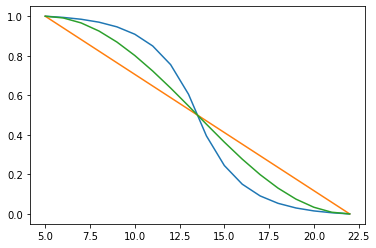

In [662]:
def exp_weight(x, d):
    """Lower positive d leads to more concave/convex weight function."""
    c = (2*d+1)**2 /(4*d)
    b = 4*d**2 / (2*d+1)**2   # = d/c
    if x >= 1/2:
        return c * b**x -d
    return 1 - exp_weight(1-x, d)

a = 5
b = 22
xs = range(a,b+1)
ys = [exp_weight(g(x,a,b),1/100) for x in xs] 
plt.plot(xs,ys)
plt.plot(xs,1-G(xs,a,b))
plt.plot(xs, [0.5 + np.cos(np.pi*g(x,a,b))/2 for x in xs])
plt.show

In [810]:
def get_Kmeans(data, variables, n_clusters, n_init=10, standardize = False, nan_replace = "mean", show_centers = True, 
               weights = None, correct_centers = False):  #correct_centers should be better True but started with False
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init)
    if variables == "all":
        variables = data.columns
    
    used_data = data[variables]
    if standardize:
        stds = used_data.std()
        used_data = used_data/stds
    if weights is not None:
        for i, var in enumerate(variables):
            used_data[var] *= weights[i]
    if nan_replace == "mean":
        used_data = used_data.fillna(used_data.mean())
        kmeans.fit(used_data)
    else:
        kmeans.fit(used_data.replace(np.nan, nan_replace))
    
    centers = kmeans.cluster_centers_
    if correct_centers:
        if standardize:
            centers = np.array(stds)*centers
        if weights is not None:
            centers = centers/weights
    if show_centers:
        print(centers)
    
    return centers, kmeans.labels_

In [664]:
def make_K_groups(data, label, variable = "Prietok", sort_groups = "mean"):
    if sort_groups is not None:   # renaming groups according to their average value of the variable of interest
        if sort_groups == "count":
            group_means = data[label].value_counts().sort_values()
        elif sort_groups == "mean":
            group_means = data.groupby(label)[variable].mean().sort_values()
        new_labels = {group: i for i, group in enumerate(group_means.index)}
        data[label+"_sorted"] = data[label].map(new_labels)
    for lab in data[label+"_sorted"].unique():
        data[variable+'_group_'+str(lab)] = np.where(data[label+"_sorted"] == lab, data[variable], np.nan)
    return data

In [665]:
def plot_K_groups(data, label, variable = "Prietok", fig_size=(8, 6), sort_groups = "mean"):
    data = make_K_groups(data, label, variable, sort_groups = sort_groups)
    plt.figure(figsize=fig_size)
    unique_labels = data[label].unique()
    unique_labels.sort()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    # Plot each cluster separately
    for i, lab in enumerate(unique_labels):
        plt.plot(data['date'], data[variable+'_group_'+str(lab)], label='Group '+str(lab), color = colors[i])
    plt.xlabel('Date and time')
    plt.ylabel(variable)
    plt.title(variable+" based on " + label)
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

In [811]:
def plot_group_ellipses(data, label, centers, variables, axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok"):
    data = make_K_groups(data, label, sort_variable, sort_groups = sort_groups)
    plt.figure(figsize=fig_size)
    unique_labels = data[label+"_sorted"].unique()
    unique_labels.sort()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    var_x = variables[axes_variables_i[0]]
    var_y = variables[axes_variables_i[1]]
    for i, lab in enumerate(unique_labels):
        cluster_data = data[data[label+"_sorted"] == lab]
        orig_lab = cluster_data[label].iloc[0]
        center = centers[orig_lab]
        # Compute covariance matrix
        cluster_data = cluster_data[[var_x,var_y]].dropna()
        cov_matrix = np.cov(cluster_data.T)

        # Eigen decomposition of covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 1]))

        # Calculate ellipse width and height
        width, height = 2 * np.sqrt(norm.ppf(0.95) * eigenvalues)

        # Plotting ellipses
        ellipse = Ellipse(xy=center[axes_variables_i], width=width, height=height, 
                          angle=angle, edgecolor='black', alpha=0.3)
        plt.gca().add_patch(ellipse)

        # Plotting cluster points
        
        plt.scatter(cluster_data[var_x], cluster_data[var_y], label=f'Cluster {lab}', color = colors[i])
    plt.scatter(centers[:, axes_variables_i[0]], centers[:, axes_variables_i[1]], marker='o', c='black', s=100, label='Centroids')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(f'KMeans Clustering ' + "--".join(variables))
    plt.legend()
    plt.show()

In [667]:
def get_PCA(data, select = None, standardize = True, nan_replace = "mean", give_rotations = False):
    if (select is not None) and (select < 1):
        pca = PCA()
    else:
        pca = PCA(n_components=select)
    if standardize:
        data = (data - data.mean())/data.std()
        
    if nan_replace == "mean":
        PCs = pca.fit_transform(data.fillna(data.mean()))
    else:
        PCs = pca.fit_transform(data.replace(np.nan, nan_replace))
    explained_var = pca.explained_variance_ratio_
    rotations = pca.components_.T
    
    if (select is not None) and (select < 1):
        select = np.argmax(np.cumsum(explained_var) >= select) + 1
        PCs = PCs[:, :select]
        explained_var = explained_var[:select]
        rotations = rotations[:, :select]
    
    if give_rotations:
        return pd.DataFrame(PCs), explained_var, rotations
    return pd.DataFrame(PCs), explained_var

In [668]:
class TS_Class:
    
    def __init__(self, data, main_var = "Prietok", 
                 start_date = None, end_date = None, periodicity = "2T", check_per = True):
        if start_date is None:
            start_date = data["date"].min()
        self.start_date = start_date
        if end_date is None:
            end_date = data["date"].max()
        self.end_date = end_date
        self.periodicity = periodicity
        
        self.data = data
        if check_per:       # ensuring we have constant periodicity in observations
            self.enforce_periodicity(start_date, end_date, periodicity)
        
        self.main_var = main_var
        self.data[main_var + "_diff_1"] = data[main_var].diff()
        self.data[main_var + "_diff_2"] = self.data[main_var + "_diff_1"].diff()
        self.models = {}
    
    def enforce_periodicity(self, start_date = None, end_date = None, periodicity = None):
        if start_date is None: start_date = self.start_date
        if end_date is None: end_date = self.end_date
        if periodicity is None: periodicity = self.periodicity
        date_range = pd.date_range(start=start_date, end=end_date, freq=periodicity)
        df = pd.DataFrame({'date': date_range})
        self.data = df.merge(self.data, on='date', how='left')   # ensuring we have constant periodicity in observations
    
    def get_period_data(self, period, start_time = None, which = 1, subset = None):
        """Period is either 'daily', 'weekly', or whole number indicating number of hours."""
        used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
        if type(period) == int:
            if start_time is None or start_time == "start":
                reference_point = used_data["date"].min()
            else:
                start_time = datetime.strptime(start_time, "%H:%M:%S")
                reference_point = used_data[used_data['date'].dt.time == start_time.time()]["date"].min()
                used_data = used_data[used_data["date"]>= reference_point]    # cut off observations before start_time
            used_data["period_index"] = used_data["date"].apply(lambda x: (x-reference_point).total_seconds() // (period * 3600))
            used_data["period_name"] = used_data["period_index"].apply(
                lambda x:f"[{reference_point + timedelta(hours=period*x)} -- {reference_point + timedelta(hours=period*(x+1))})")
        
        elif period == "daily":
            used_data['period_name'] = used_data['date'].dt.date
            
        elif period == "weekly":
            first = used_data['date'].dt.strftime('%Y-%W').apply(
                lambda x: x.split("-")).apply(
                lambda y: datetime.strptime(f'{y[0]}-W{y[1]}-1', "%Y-W%U-%w") )
            used_data['period_name'] = first.apply(
                lambda x: f"{x.strftime('%Y-%m-%d')} -- {(x+timedelta(days=6)).strftime('%Y-%m-%d')}")
                       
        else:
            raise NameError('Period which is not recognized have been entered. "weekly" or "daily" are expected.')
        
        if which == 1:
            self.period_data = used_data.groupby('period_name')
        else:
            self.period_data_2 = used_data.groupby('period_name')
        
    def get_y_lim(self, value, negative = False):
        if negative:
            value = - value
        if value < 0.05: return value*1.1
        if value < 0.09: return 0.1
        if value < 0.47: return 0.5
        if value < 0.9: return 1
        if value < 2.45: return 2.5
        if value < 4.9: return 5
        if value < 9.5: return 10
        if value < 19: return 20
        return value*1.1
    
    def get_rob_subset(self, variable, rob_quantile, two_sided):
        subset = self.data[variable] < self.data[variable].quantile(rob_quantile)
        if two_sided:
            L = self.data[variable].quantile(1-rob_quantile)
            U = self.data[variable].quantile(rob_quantile)
            subset =  self.data[variable].apply(lambda x: L<x<U)
        return subset
    
    def get_measures(self, variable, include, window, which = 1, 
                     quantile = 0.5, rob_quantile = 0.8, two_sided_rob_q = False, rob_q_mult = 1):   
        suff = "" if which == 1 else "_2"
        if two_sided_rob_q:
            rob_quantile = 0.5 + rob_quantile/2
        if "CMA" in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
        if ("CMA_bounds" in include) or ("CMA_bounds_2sd" in include):
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
            self.data['CMA_upper'+suff] = self.data['Centered_Moving_Average'+suff] + self.data['Centered_Moving_SD'+suff]
            self.data['CMA_lower'+suff] = self.data['Centered_Moving_Average'+suff] - self.data['Centered_Moving_SD'+suff]
            if "CMA_bounds_2sd" in include:
                self.data['CMA_upper_2sd'+suff] = self.data['Centered_Moving_Average'+suff] + 2*self.data['Centered_Moving_SD'+suff]
                self.data['CMA_lower_2sd'+suff] = self.data['Centered_Moving_Average'+suff] - 2*self.data['Centered_Moving_SD'+suff]
        if "CMA_rob_bounds"  in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()
            self.data['CMA_upper_rob'+suff] = self.data['Centered_Moving_Average'+suff] + rob_q_mult*robust_sd
            self.data['CMA_lower_rob'+suff] = self.data['Centered_Moving_Average'+suff] - rob_q_mult*robust_sd
                
        if "MA" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
        if ("MA_bounds" in include) or ("MA_bounds_2sd" in include):
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
            self.data['MA_upper'+suff] = self.data['Moving_Average'+suff] + self.data['Moving_SD'+suff]
            self.data['MA_lower'+suff] = self.data['Moving_Average'+suff] - self.data['Moving_SD'+suff]
            if "MA_bounds_2sd" in include:
                self.data['MA_upper_2sd'+suff] = self.data['Moving_Average'+suff] + 2*self.data['Moving_SD'+suff]
                self.data['MA_lower_2sd'+suff] = self.data['Moving_Average'+suff] - 2*self.data['Moving_SD'+suff]
        if "MA_rob_bounds" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()
            self.data['MA_upper_rob'+suff] = self.data['Moving_Average'+suff] + rob_q_mult*robust_sd
            self.data['MA_lower_rob'+suff] = self.data['Moving_Average'+suff] - rob_q_mult*robust_sd
        
        if "CMSD" in include:
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
        if "MSD" in include:
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
        if "tot_avg" in include:
            self.data['total_avg'+suff] = self.data[variable].mean()
        if "quant" in include:
            self.data['quantile'+suff] = self.data[variable].quantile(quantile)
        if "robust_avg" in include:
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            self.data['r_avg'+suff] = self.data[subset][variable].mean()
            
    
    def get_ax(self, ax, group_data, unit, variable, include, rain_lims, which, include_rain = True, marker = None):  
        suff = "" if which == 1 else "_2"
        ax.plot(group_data['date'], group_data[variable], label = variable)
        include_c = include.copy()   
        if "CMA" in include_c:
            ax.plot(group_data['date'], group_data['Centered_Moving_Average'+suff], color="red", label = "CMA")
            include_c.remove("CMA")
        
        if "CMA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper_2sd'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower_2sd'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds_2sd")
        if "CMA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds")
        
        if "CMA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper_rob'+suff], color="black", label = "CMA_rob_Up")
            ax.plot(group_data['date'], group_data['CMA_lower_rob'+suff], color="black", label = "CMA_rob_L")
            include_c.remove("CMA_rob_bounds")
            
        if "MA" in include_c:
            ax.plot(group_data['date'], group_data['Moving_Average'+suff], color="brown", label = "MA")
            include_c.remove("MA")
        if "MA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds")
        if "MA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper_2sd'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower_2sd'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds_2sd")
        if "MA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper_rob'+suff], color="black", label = "MA_rob_Up")
            ax.plot(group_data['date'], group_data['MA_lower_rob'+suff], color="black", label = "MA_rob_L")
            include_c.remove("MA_rob_bounds")
            
        if "CMSD" in include_c:
            ax.plot(group_data['date'], group_data['Centered_Moving_SD'+suff], color="green", label = "CMSD")
            include_c.remove("CMSD")
        if "MSD" in include_c:
            ax.plot(group_data['date'], group_data['Moving_SD'+suff], color="black", label = "MSD")
            include_c.remove("MSD")
        if "tot_avg" in include_c:
            ax.plot(group_data['date'], group_data['total_avg'+suff], color="black", label = "tot_avg")
            include_c.remove("tot_avg")
        if "quant" in include_c:
            ax.plot(group_data['date'], group_data['quantile'+suff], color="black", label = "quantile")
            include_c.remove("quant")
        if "robust_avg" in include_c:
            ax.plot(group_data['date'], group_data['r_avg'+suff], color="black", label = "robust_avg")
            include_c.remove("robust_avg")
        
        max_y = group_data[variable].max()
        min_y = group_data[variable].min()
        #print(variable+str(min_y))    #########
        #print(variable+str(max_y))    #########
        #print(variable+" no-nan "+str(max_y))    #########
        for item in include_c:
            if item in group_data.columns:
                ax.plot(group_data['date'], group_data[item], label = item)
                max_y = max(max_y, group_data[item].max())
                min_y = min(min_y, group_data[item].min())
                #print(item+str(min_y))    #########
               # print(item+str(max_y))    #########
                        
        ax.set_title(f'Time Series for {unit}')
        ax.set_xlabel('Date and Time')
        ax.set_ylabel(variable)
        ax.legend(loc="upper left")
        ylim_up = self.get_y_lim(max_y)
        ylim_down = -self.get_y_lim(min_y, True) if min_y < 0 else 0
 #       print("down "+str(ylim_down))            ##############
 #       print("up "+str(ylim_up))
        try:
            ax.set_ylim(ylim_down, ylim_up)
        except:
            print("down "+str(ylim_down))            ##############
            print("up "+str(min_y))
        for line in ax.lines:
            line.set_marker(marker)
            
        if include_rain:
            ax2 = ax.twinx()
            ax2.set_ylim(*rain_lims)
            ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
            ax2.invert_yaxis()
            ax2.set_ylabel('rain (Upside-Down)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')
            return (ax, ax2)
        return (ax, "")
        
    def plot(self, variable = None, period = "all", start_time = None, subset = None, 
             quantile = 0.5, rob_quantile = 0.8, two_sided_rob_q = False, rob_q_mult = 1,
             include = ["CMA", "CMA_bounds"], window = 30, rain_lims = (0,5), fig_size = None, 
            variable_2 = None, start_time_2 = None, include_2 = ["CMA", "CMA_bounds"], window_2 = 30, 
            quantile_2 = 0.5, rob_quantile_2 = 0.8, two_sided_rob_q_2 = False, rob_q_mult_2 = 1, 
             double_plot = False, include_rain = True, marker = None):
        if variable is None:
            variable = self.main_var
        
        self.get_measures(variable, include, window, which = 1, quantile = quantile, rob_quantile = rob_quantile, 
                          two_sided_rob_q = two_sided_rob_q, rob_q_mult = rob_q_mult)
        if start_time_2 is not None:
            if variable_2 is None: variable_2 = variable
            self.get_measures(variable_2, include_2, window_2, which = 2, quantile = quantile_2, 
                              rob_quantile = rob_quantile_2, two_sided_rob_q = two_sided_rob_q_2, rob_q_mult = rob_q_mult_2)
                
        if period == "all":
            self.data["const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.period_data = used_data.groupby("const")
        else:
            self.get_period_data(period, start_time, 1, subset)
        
        if start_time_2 is None:
            self.period_data_2 = self.period_data
        else:
            if period == "all":
                self.data["const"] = "whole data"
                used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
                self.period_data_2 = used_data.groupby("const")
            else:
                self.get_period_data(period, start_time_2, 2, subset)
            
        for grouped_1, grouped_2 in zip(self.period_data,self.period_data_2):
            unit_1, group_data_1 = grouped_1
            unit_2, group_data_2 = grouped_2
            
            if double_plot:
                group_data_1.set_index('date', inplace=True)
                group_data_2.set_index('date', inplace=True)
                group_data_1[variable].plot(xlabel = 'Date and Time', ylabel = variable, label = variable)
                group_data_2[variable_2].plot(label = variable_2)
                
                plt.title(f'Time Series for {unit_1}')
                plt.legend(loc="upper left")
                plt.show()
                continue
            
            if start_time_2 is not None:
                if fig_size is None: 
                    fig_size = (19, 6)
                fig, ax = plt.subplots(1, 2, figsize=fig_size)
                ax[0], axb1 = self.get_ax(ax[0], group_data_1, unit_1, variable, include, rain_lims, 1, include_rain, marker)
                ax[1], axb2 = self.get_ax(ax[1], group_data_2, unit_2, variable_2, include_2, rain_lims, 2, include_rain, marker)
            else:
                if fig_size is None: 
                    fig_size = (10, 6)
                fig, ax = plt.subplots(figsize=fig_size)
                ax, axb1 = self.get_ax(ax, group_data_1, unit_1, variable, include, rain_lims, 1, include_rain, marker)
            plt.grid(True)
            plt.show()
            
    def groupby(self, groupby):
        if groupby is None:
            self.data["const"] = "whole data"
            grouped = self.data.groupby("const")
        else:
            if groupby == "daily":
                self.data['period_name'] = self.data['date'].dt.date
                grouped = self.data.groupby("period_name")
            elif groupby == "weekly":
                self.data['period_name'] = self.data['date'].dt.strftime('%Y-%W')
                grouped = self.data.groupby("period_name")
            else:
                grouped = self.data.groupby(groupby)
        return grouped
    
    def get_ETS(self, variable, model_name, groupby = None, show_progress = True,
                error="add", trend="add", seasonal="add", damped_trend=False, seasonal_periods=720):
        """Note: there is 720 observations per day, for 1 day periodicity we need 720 seasonal components, which is too 
        many for practical estimatation - careful about seasonal components."""
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)
                        
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ETSModel(grouped_data[variable], error=error, trend=trend, seasonal=seasonal, 
                                            damped_trend=damped_trend, seasonal_periods=seasonal_periods)
            result = model.fit()
            grouped_data[model_name + "_fitted"] = result.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def get_ARIMA(self, p, d, q, model_name, variable = None,  groupby = None, show_progress = True):
        if variable is None: variable = self.main_var
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)           
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ARIMA(grouped_data[variable], order=(p, d, q))
            results = model.fit()
            grouped_data[model_name + "_fitted"] = results.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def ARIMA_diagnostics(self, results, unit, model_name, show_summary = True):
        print("ARIMA diagnostics for " + model_name + " " + str(unit))
        if show_summary:
            print(results.summary())
        residuals = results.resid
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax[0, 0].plot(residuals)
        ax[0, 0].set_title('Residuals')
        lags_1 = min(40, len(residuals)-1)
        lags_2 = min(40, int(len(residuals)/2)-2)
        sm.graphics.tsa.plot_acf(residuals, lags=lags_1, ax=ax[0, 1])
        sm.graphics.tsa.plot_pacf(residuals, lags=lags_2, ax=ax[1, 0])
        plt.show()

        # Ljung-Box test for autocorrelation in residuals
        acf, q_val, p_val = sm.tsa.acf(residuals, fft=True, qstat=True)
        p_val_df = pd.DataFrame({'Lag': range(1, len(p_val) + 1), 'P-Value': p_val})

        print(p_val_df)
    
    def ARIMAs_diagnostics(self, model_name, subset = None):
        models = self.models[model_name]
        if subset is not None:
            models = models[subset]
        for unit, mod, res in models:
            self.ARIMA_diagnostics(res, unit, model_name)
            
    def get_time_trend(self, values, give = "slope"):
        """Values should have a data series format with specified index which represents time order."""
        X = sm.add_constant(values.index)
        model = sm.OLS(values, X).fit()
        if give == "slope":
            return model.params[1]
        if give == "constant":
            return model.params[0]
        if give == "model":
            return model

In [854]:
ts_data = TS_Class(data)

# TO DO:
* classify observations
* plot original TS + marked categories of observations
* correct mistakes
* plot corrected TS + marked categories of observations (orginal values)

In [856]:
def prepare_classification(data, main_var):
    data[main_var+"_SD_3"] = data[main_var].rolling(window=3, center=True).std()
    return data

In [847]:
def classify(data, main_var):
    if data[main_var] == 0:
        return "zero_"+main_var
    if data[main_var+"_SD_3"] == 0:
        return "constant_"+main_var
    return "OK"
    # to use as  data[main_var + "_categories"] = data[main_var].apply(classify)

In [869]:
def get_classified_series(data, main_var):
    categories = data[main_var + "_categories"].unique()
    for cat in categories:
        data[main_var + "_" + cat] = np.where(data[main_var + "_categories"]==cat, data[main_var], np.nan)
    return data

In [866]:
ts_data.data = prepare_classification(ts_data.data, "Prietok")

ts_data.data["Prietok_categories"] = ts_data.data.apply(classify, args = (["Prietok"]), axis=1)

In [870]:
ts_data.data = get_classified_series(ts_data.data, "Prietok")

In [874]:
ts_data.data["Prietok_constant_Prietok"].value_counts()

0.42    2
3.35    2
1.66    2
0.64    2
0.44    2
1.60    2
4.45    1
1.69    1
0.40    1
0.82    1
1.37    1
0.73    1
2.11    1
1.65    1
1.52    1
2.91    1
1.53    1
2.55    1
2.76    1
1.80    1
0.47    1
1.38    1
0.84    1
1.61    1
1.85    1
0.45    1
5.12    1
1.22    1
1.06    1
2.84    1
1.97    1
1.88    1
0.51    1
1.99    1
0.43    1
0.95    1
Name: Prietok_constant_Prietok, dtype: int64

# explorative plots

In [ ]:
ts_data.plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"])

In [ ]:
ts_data.plot(variable = "Prietok_diff_1",include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12,  
             two_sided_rob_q = True, rob_q_mult = 2,
             start_time="0:00:00", start_time_2="6:00:00", include_2 = ["CMA_rob_bounds","CMA_bounds_2sd"], 
             two_sided_rob_q_2 = True, rob_q_mult_2 = 2)

In [ ]:
ts_data.plot(include=list("CMA_bounds"), period=12, variable_2 = "Prietok_diff_1",
             start_time_2="start", include_2 = list("CMA_bounds"))

In [ ]:
ts_data.plot(variable = "Prietok_diff_1", include=list("CMA_bounds"), period=12, variable_2 = "Prietok_diff_2",
             start_time_2="start", include_2 = list("CMA_bounds"))

# ARIMA experiments

In [ ]:
ts_data.get_ARIMA(5,1,5, "ARIMA_5_1_5", groupby = "daily")

In [ ]:
ts_data.ARIMAs_diagnostics("ARIMA_5_1_5")

In [ ]:
ts_data.plot(variable_2 = "ARIMA_5_1_5_fitted", start_time_2 = "start", include=[], include_2 = [], period = 12,
            double_plot = True)

In [ ]:
ts_data.plot(variable_2 = "ARIMA_2_1_2_fitted", start_time_2 = "start", include=[], include_2 = [], period = 12,
            double_plot = True)

# Derivatives ignoring noise

In [680]:
ts_data.data["slopes_60"] = ts_data.data['Prietok'].rolling(window=60, center=True).apply(ts_data.get_time_trend)

In [681]:
ts_data.data["slopes_60"] = ts_data.data["slopes_60"]*60

In [682]:
subset = ts_data.get_rob_subset("slopes_60", 0.8, True)
ts_data.data["slope_60_sd_L"] =  ts_data.data["slopes_60"].mean() - ts_data.data[subset]["slopes_60"].std()
ts_data.data["slope_60_sd_U"] = ts_data.data["slopes_60"].mean() + ts_data.data[subset]["slopes_60"].std()

In [ ]:
ts_data.plot(include = ["slopes_60","slope_60_sd_L","slope_60_sd_U"], period = 12)

In [684]:
ts_data.data["slopes_15"] = ts_data.data['Prietok'].rolling(window=15, center=True).apply(ts_data.get_time_trend)

In [685]:
ts_data.data["slopes_15"] = ts_data.data["slopes_15"]*15

In [686]:
subset = ts_data.get_rob_subset("slopes_15", 0.8, True)
ts_data.data["slopes_15_sd_L"] =  ts_data.data["slopes_15"].mean() - ts_data.data[subset]["slopes_15"].std()
ts_data.data["slopes_15_sd_U"] = ts_data.data["slopes_15"].mean() + ts_data.data[subset]["slopes_15"].std()

In [ ]:
ts_data.plot(include = ["slopes_15","slopes_15_sd_L","slopes_15_sd_U"], period = 12)

# ETS experiments

In [ ]:
ts_data.get_ETS("Prietok", "ETS_AAN", groupby = None, show_progress = True, seasonal = None)

In [ ]:
ts_data.plot(include=list("CMA_bounds"), period=12, variable_2 = "ETS_AAN_fitted",
             start_time_2="start", include_2 = list("CMA_bounds"))

In [ ]:
ts_data.plot(include=list("CMA_bounds"), period=12, variable_2 = "ETS_AAN_fitted",
             start_time_2="start", double_plot = True)

# Others

In [693]:
ts_data.data['Moving_SD_30'] = ts_data.data["Prietok"].rolling(window=30, center=False).std()

In [ ]:
ts_data.plot(include = list(("MSD", "quant")), window = 180, start_time_2 = "start",
             include_2=list(("CMA","MA","robust_avg")), period=12, 
             variable_2 = "Moving_SD_30", window_2 = 180, quantile = 0.8, rob_quantile_2 = 0.8)

In [ ]:
ts_data.plot(include=["CMA"], period=12, window = 30,
             start_time_2="start", include_2 = ["CMA"], window_2 = 5)

# Fooling around with K-Means

In [ ]:
ts_data.plot(include=[])

In [ ]:
ts_data.data["Prietok"].hist(bins=20)

## grouping for rain detection based on 1 variable
ie finding optimal cut-offs deciding for rain vs non-rain

In [698]:
ts_data.data["log_prietok"] = np.log(data["Prietok"])
ts_data.data["log_prietok"] = ts_data.data["log_prietok"].replace(-np.inf, np.nan) 

C:\Users\am\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [699]:
ts_data.data["exp_prietok"] = np.exp(data["Prietok"])
cut = ts_data.data["exp_prietok"].quantile(0.8)
ts_data.data["exp_prietok_cut"] = np.exp(data["Prietok"]).apply(lambda x: min(x,cut))

In [ ]:
ts_data.data["log_prietok"].hist()

In [ ]:
ts_data.data["exp_prietok"].hist(bins=30)

In [ ]:
ts_data.data["exp_prietok_cut"].hist(bins=30)

In [703]:
ts_data.data[["Prietok","log_prietok","exp_prietok","exp_prietok_cut"]].describe()

,Prietok,log_prietok,exp_prietok,exp_prietok_cut
count,22319.000000,22191.000000,2.231900e+04,22319.000000
mean,3.598630,0.933708,1.150587e+13,34.309235
std,4.185152,0.793634,7.998814e+14,39.721366
min,0.000000,-4.605170,1.000000e+00,1.000000
25%,1.540000,0.438255,4.664590e+00,4.664590
50%,2.520000,0.932164,1.242860e+01,12.428597
75%,4.090000,1.413423,5.973989e+01,59.739892
max,39.150000,3.667400,1.006072e+17,104.584986


In [704]:
ts_data.data[["Prietok","log_prietok","exp_prietok","exp_prietok_cut"]].isna().sum()

Prietok              1
log_prietok        129
exp_prietok          1
exp_prietok_cut      1
dtype: int64

In [705]:
_, ts_data.data["rain_labels_1"]= get_Kmeans(ts_data.data, ["Prietok"], 2)

_, ts_data.data["rain_labels_2"]= get_Kmeans(ts_data.data, ["log_prietok"], 2, nan_replace = 1)

_, ts_data.data["rain_labels_3"]= get_Kmeans(ts_data.data, ["exp_prietok_cut"], 2)

[[ 2.87371581]
 [20.9925196 ]]
[[0.31479639]
 [1.53351156]]
[[11.993703  ]
 [97.98864152]]


In [ ]:
plot_K_groups(ts_data.data, "rain_labels_1")
plot_K_groups(ts_data.data, "rain_labels_2")
plot_K_groups(ts_data.data, "rain_labels_3")

In [ ]:
cut = ts_data.data["Prietok"].quantile(0.8)
print(cut)
ts_data.data["rain_labels_4"] = ts_data.data["Prietok"].apply(lambda x: 0 if x<cut else 1)
plot_K_groups(ts_data.data, "rain_labels_4")

In [ ]:
_, ts_data.data["rain_labels_1"]= get_Kmeans(ts_data.data, ["Prietok"], 3)

_, ts_data.data["rain_labels_2"]= get_Kmeans(ts_data.data, ["log_prietok"], 3, nan_replace = 1)

_, ts_data.data["rain_labels_3"]= get_Kmeans(ts_data.data, ["exp_prietok_cut"], 3)

plot_K_groups(ts_data.data, "rain_labels_1")
plot_K_groups(ts_data.data, "rain_labels_2")
plot_K_groups(ts_data.data, "rain_labels_3")

In [ ]:
_, ts_data.data["rain_labels_1"]= get_Kmeans(ts_data.data, ["Prietok"], 4)

_, ts_data.data["rain_labels_2"]= get_Kmeans(ts_data.data, ["log_prietok"], 4, nan_replace = 1)

_, ts_data.data["rain_labels_3"]= get_Kmeans(ts_data.data, ["exp_prietok_cut"], 4)

plot_K_groups(ts_data.data, "rain_labels_1")
plot_K_groups(ts_data.data, "rain_labels_2")
plot_K_groups(ts_data.data, "rain_labels_3")

In [710]:
ts_data.data = make_K_groups(ts_data.data, "rain_labels_1", "Prietok")

In [ ]:
ts_data.plot(variable = 'Prietok_group_0',include=["Prietok_group_1","Prietok_group_2","Prietok_group_3"],period=12,
            marker = "*")

In [712]:
ts_data.data = make_K_groups(ts_data.data, "rain_labels_2", "Prietok")

In [ ]:
ts_data.plot(variable = 'Prietok_group_0',include=["Prietok_group_1","Prietok_group_2","Prietok_group_3"],period=12,
            marker = "o")

### Why are groups based on exponential and logarithm mixing? There are observations which are eg. in the lowest group but observation with smaller flow are in the group of larger flows, which should not happen for simple grouping based on 1 variable which is a strictly monotonic transformation of the flow...

#### note for rain detection: making different groupings for night (23:00-5:00) and day (separate datasets or add indicator as the second variable to KMeans)

## General clustering exploration based on additional engineered features

* try making new variables indicating time periods, or moving measure etc as additional input for clustering
* scaling of multiple variables - standardize, choose weights


In [714]:
ts_data.data['MA_30'] = ts_data.data["Prietok"].rolling(window=30, center=True).mean()
ts_data.data['Moving_SD_30'] = ts_data.data["Prietok"].rolling(window=30, center=True).std()
ts_data.data['MA_5'] = ts_data.data["Prietok"].rolling(window=5, center=True).mean()
ts_data.data['MA_15'] = ts_data.data["Prietok"].rolling(window=15, center=True).mean()
ts_data.data['Moving_SD_15'] = ts_data.data["Prietok"].rolling(window=15, center=True).std()

ts_data.data['MA_90'] = ts_data.data["Prietok"].rolling(window=90, center=True).mean()  # 3h
ts_data.data['Moving_SD_90'] = ts_data.data["Prietok"].rolling(window=90, center=True).std()
ts_data.data['MA_180'] = ts_data.data["Prietok"].rolling(window=180, center=True).mean()  #6h
ts_data.data['Moving_SD_180'] = ts_data.data["Prietok"].rolling(window=180, center=True).std()

#ts_data.data["slopes_15"] = ts_data.data['Prietok'].rolling(window=15, center=True).apply(ts_data.get_time_trend)
#ts_data.data["slopes_30"] = ts_data.data['Prietok'].rolling(window=30, center=True).apply(ts_data.get_time_trend)
#ts_data.data["slopes_60"] = ts_data.data['Prietok'].rolling(window=60, center=True).apply(ts_data.get_time_trend)

ts_data.data['index'] = ts_data.data.index

hours = ts_data.data['date'].dt.hour
ts_data.data['day']  = ((hours < 23) & (hours >= 5)).astype(int)

In [715]:
ts_data.data["slopes_15"] = slopes_15
ts_data.data["slopes_30"] = slopes_30
ts_data.data["slopes_60"] = slopes_60

In [716]:
features = ['MA_5','MA_15','MA_30','MA_90','MA_180','Moving_SD_15','Moving_SD_30','Moving_SD_90','Moving_SD_180',
           "slopes_15", "slopes_30", "slopes_60", "index", "day", "Prietok", "Prietok_diff_1", "Prietok_diff_2"]

In [717]:
_, ts_data.data["clusters_1"]= get_Kmeans(ts_data.data, ['MA_30','Moving_SD_30','MA_90'], 
                                             4, standardize = True, weights = None)

_, ts_data.data["clusters_2"]= get_Kmeans(ts_data.data, ["Prietok",'MA_30','Moving_SD_30','MA_90'], 
                                             4, standardize = True, weights = None)

[[1.18400359 0.74401382 1.42429742]
 [5.86547124 4.15810528 5.66818422]
 [2.90402651 3.40018912 3.13758821]
 [0.48765482 0.23737462 0.59065514]]
[[0.44254661 0.49290505 0.24830348 0.60201505]
 [2.66849439 3.11265897 3.76505032 3.32826462]
 [6.00569463 6.03248847 3.7945075  5.70451265]
 [1.13136806 1.20860322 0.76192294 1.4503449 ]]


In [ ]:
plot_K_groups(ts_data.data, "clusters_1")
plot_K_groups(ts_data.data, "clusters_2")

In [ ]:
_, ts_data.data["clusters_1"]= get_Kmeans(ts_data.data, ['MA_30','Moving_SD_30','Moving_SD_90'], 
                                             4, standardize = True, weights = None, show_centers = False)

_, ts_data.data["clusters_2"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_30','Moving_SD_30','MA_90'], 
                                             4, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_3"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_30','Moving_SD_30','MA_90'], 
                                             4, standardize = True, weights = [1,3,1,1], show_centers = False)
_, ts_data.data["clusters_4"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_5','Moving_SD_30','MA_90'], 
                                             4, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_5"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_5','Moving_SD_30','MA_90'], 
                                             2, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "clusters_1")
plot_K_groups(ts_data.data, "clusters_2")
plot_K_groups(ts_data.data, "clusters_3")
plot_K_groups(ts_data.data, "clusters_4")
plot_K_groups(ts_data.data, "clusters_5")

In [ ]:
_, ts_data.data["clusters_1"]= get_Kmeans(ts_data.data, ['MA_30','Moving_SD_30','Moving_SD_90'], 
                                             2, standardize = True, weights = None, show_centers = False)

_, ts_data.data["clusters_2"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_30','Moving_SD_30','MA_90'], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_3"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_30','Moving_SD_30','MA_90'], 
                                             2, standardize = True, weights = [1,3,1,1], show_centers = False)
_, ts_data.data["clusters_4"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_5','Moving_SD_30','MA_90'], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_5"]= get_Kmeans(ts_data.data, ["Moving_SD_90",'MA_5','Moving_SD_30','MA_90',"index"], 
                                             2, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "clusters_1")
plot_K_groups(ts_data.data, "clusters_2")
plot_K_groups(ts_data.data, "clusters_3")
plot_K_groups(ts_data.data, "clusters_4")
plot_K_groups(ts_data.data, "clusters_5")

In [ ]:
_, ts_data.data["clusters_i"]= get_Kmeans(ts_data.data, ["index",'Moving_SD_30'], 
                                             2, standardize = True, weights = [1,5], show_centers = False)
plot_K_groups(ts_data.data, "clusters_i")

In [ ]:
_, ts_data.data["clusters_1"]= get_Kmeans(ts_data.data, ["MA_5"], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_2"]= get_Kmeans(ts_data.data, ["MA_30"], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_3"]= get_Kmeans(ts_data.data, ["Moving_SD_30"], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_4"]= get_Kmeans(ts_data.data, ["Moving_SD_90"], 
                                             2, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "clusters_1")
plot_K_groups(ts_data.data, "clusters_2")
plot_K_groups(ts_data.data, "clusters_3")
plot_K_groups(ts_data.data, "clusters_4")

In [ ]:
_, ts_data.data["clusters_1"]= get_Kmeans(ts_data.data, ["MA_5","index"], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_2"]= get_Kmeans(ts_data.data, ["MA_30","index"], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_3"]= get_Kmeans(ts_data.data, ["Moving_SD_30","index"], 
                                             2, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_4"]= get_Kmeans(ts_data.data, ["Moving_SD_90","index"], 
                                             2, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "clusters_1")
plot_K_groups(ts_data.data, "clusters_2")
plot_K_groups(ts_data.data, "clusters_3")
plot_K_groups(ts_data.data, "clusters_4")

In [ ]:
_, ts_data.data["clusters_i"]= get_Kmeans(ts_data.data, ["index",'Moving_SD_90',"MA_5"], 
                                             2, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "clusters_i")

In [ ]:
_, ts_data.data["clusters_i"]= get_Kmeans(ts_data.data, ['Moving_SD_30',"MA_30"], 
                                             7, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_i2"]= get_Kmeans(ts_data.data, ['Moving_SD_30',"MA_30","index"], 
                                             7, standardize = True, weights = None, show_centers = False)
_, ts_data.data["clusters_i3"]= get_Kmeans(ts_data.data, ['Moving_SD_30',"MA_30","index"], 
                                             7, standardize = True, weights = [1,1,0.3], show_centers = False)
plot_K_groups(ts_data.data, "clusters_i")
plot_K_groups(ts_data.data, "clusters_i2")
plot_K_groups(ts_data.data, "clusters_i3")

In [726]:
features

['MA_5',
 'MA_15',
 'MA_30',
 'MA_90',
 'MA_180',
 'Moving_SD_15',
 'Moving_SD_30',
 'Moving_SD_90',
 'Moving_SD_180',
 'slopes_15',
 'slopes_30',
 'slopes_60',
 'index',
 'day',
 'Prietok',
 'Prietok_diff_1',
 'Prietok_diff_2']

In [ ]:
C1, ts_data.data["general_clusters_1"]= get_Kmeans(ts_data.data, features, 
                                             7, standardize = True, weights = None, show_centers = False)
C2, ts_data.data["general_clusters_2"]= get_Kmeans(ts_data.data, ['MA_15','MA_90','Moving_SD_30','slopes_30','day'], 
                                             7, standardize = True, weights = None, show_centers = False)
C3, ts_data.data["general_clusters_3"]= get_Kmeans(ts_data.data, ['MA_15','MA_90','Moving_SD_30','slopes_30','day',"index"], 
                                             7, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "general_clusters_1")
plot_K_groups(ts_data.data, "general_clusters_2")
plot_K_groups(ts_data.data, "general_clusters_3")

In [728]:
C3_sc = np.array(ts_data.data[['MA_15','MA_90','Moving_SD_30','slopes_30','day',"index"]].std())*C3

In [ ]:
plot_group_ellipses(ts_data.data, "general_clusters_3", C3_sc, 
                    ['MA_15','MA_90','Moving_SD_30','slopes_30','day',"index"], axes_variables_i = [0,2],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [ ]:
plot_group_ellipses(ts_data.data, "general_clusters_3", C3_sc, 
                    ['MA_15','MA_90','Moving_SD_30','slopes_30','day',"index"], axes_variables_i = [0,3],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [ ]:
plot_group_ellipses(ts_data.data, "general_clusters_3", C3_sc, 
                    ['MA_15','MA_90','Moving_SD_30','slopes_30','day',"index"], axes_variables_i = [4,5],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [ ]:
C_s1, ts_data.data["simple_clusters_1"]= get_Kmeans(ts_data.data, ['MA_5','Moving_SD_30'], 
                                             2, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "simple_clusters_1")

C_s2, ts_data.data["simple_clusters_2"]= get_Kmeans(ts_data.data, ['MA_5','Moving_SD_30'], 
                                             3, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "simple_clusters_2")

C_s3, ts_data.data["simple_clusters_3"]= get_Kmeans(ts_data.data, ['MA_5','Moving_SD_30'], 
                                             4, standardize = True, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "simple_clusters_3")

In [ ]:
C_s1_sc = np.array(ts_data.data[['MA_5','Moving_SD_30']].std())*C_s1
C_s2_sc = np.array(ts_data.data[['MA_5','Moving_SD_30']].std())*C_s2
C_s3_sc = np.array(ts_data.data[['MA_5','Moving_SD_30']].std())*C_s3

In [ ]:
plot_group_ellipses(ts_data.data, "simple_clusters_1", C_s1, 
                    ['MA_5','Moving_SD_30'], axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")
plot_group_ellipses(ts_data.data, "simple_clusters_2", C_s2, 
                    ['MA_5','Moving_SD_30'], axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")
plot_group_ellipses(ts_data.data, "simple_clusters_3", C_s3, 
                    ['MA_5','Moving_SD_30'], axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [ ]:
C_s1b, ts_data.data["simple_clusters_1b"]= get_Kmeans(ts_data.data, ['MA_5','Moving_SD_30'], 
                                             2, standardize = True, weights = [2,1], show_centers = False,
                                                     correct_centers = True)
plot_K_groups(ts_data.data, "simple_clusters_1b")

C_s2b, ts_data.data["simple_clusters_2b"]= get_Kmeans(ts_data.data, ['MA_5','Moving_SD_30'], 
                                             3, standardize = True, weights = [2,1], show_centers = False,
                                                     correct_centers = True)
plot_K_groups(ts_data.data, "simple_clusters_2b")

C_s3b, ts_data.data["simple_clusters_3b"]= get_Kmeans(ts_data.data, ['MA_5','Moving_SD_30'], 
                                             4, standardize = True, weights = [2,1], show_centers = False,
                                                     correct_centers = True)
plot_K_groups(ts_data.data, "simple_clusters_3b")

In [844]:
C_s1b_sc = C_s1b
C_s2b_sc = C_s2b
C_s3b_sc = C_s3b

In [834]:
#C_s1b_sc = np.array(ts_data.data[['MA_5','Moving_SD_30']].std())*C_s1b*[0.5,1]
#C_s2b_sc = np.array(ts_data.data[['MA_5','Moving_SD_30']].std())*C_s2b*[0.5,1]
#C_s3b_sc = np.array(ts_data.data[['MA_5','Moving_SD_30']].std())*C_s3b*[0.5,1]

In [ ]:
plot_group_ellipses(ts_data.data, "simple_clusters_1b", C_s1b_sc, 
                    ['MA_5','Moving_SD_30'], axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")
plot_group_ellipses(ts_data.data, "simple_clusters_2b", C_s2b_sc, 
                    ['MA_5','Moving_SD_30'], axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")
plot_group_ellipses(ts_data.data, "simple_clusters_3b", C_s3b_sc, 
                    ['MA_5','Moving_SD_30'], axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [732]:
features

['MA_5',
 'MA_15',
 'MA_30',
 'MA_90',
 'MA_180',
 'Moving_SD_15',
 'Moving_SD_30',
 'Moving_SD_90',
 'Moving_SD_180',
 'slopes_15',
 'slopes_30',
 'slopes_60',
 'index',
 'day',
 'Prietok',
 'Prietok_diff_1',
 'Prietok_diff_2']

In [733]:
C1_sc = np.array(ts_data.data[features].std())*C1

In [ ]:
plot_group_ellipses(ts_data.data, "general_clusters_3", C1_sc, 
                    features, axes_variables_i = [2,-2],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [ ]:
ts_data.data = make_K_groups(ts_data.data, "general_clusters_1", "Prietok", sort_groups = "count")

n=7
include = ["Prietok_group_"+str(i) for i in range(1,n)]
ts_data.plot(variable = 'Prietok_group_0',include=include,period=12,
            marker = "o")

In [ ]:
ts_data.data = make_K_groups(ts_data.data, "general_clusters_2", "Prietok", sort_groups = "count")

n=7
include = ["Prietok_group_"+str(i) for i in range(1,n)]
ts_data.plot(variable = 'Prietok_group_0',include=include,period=12,
            marker = "o")

In [ ]:
ts_data.data = make_K_groups(ts_data.data, "general_clusters_3", "Prietok", sort_groups = "count")

n=7
include = ["Prietok_group_"+str(i) for i in range(1,n)]
ts_data.plot(variable = 'Prietok_group_0',include=include,period=12,
            marker = "o")

nans as extremes - something about names of the groups?



In [738]:
PCAs, _ = get_PCA(ts_data.data[features])
PC_cols = ["PC_"+str(i+1) for i in range(PCAs.shape[1])]
ts_data.data[PC_cols] = PCAs

In [ ]:
C_pca, ts_data.data["PCA_clusters_1"]= get_Kmeans(ts_data.data, PC_cols, 
                                             7, standardize = False, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "PCA_clusters_1")

In [ ]:
plot_group_ellipses(ts_data.data, "PCA_clusters_1", C_pca, 
                    PC_cols, axes_variables_i = [1,5],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")
plot_group_ellipses(ts_data.data, "PCA_clusters_1", C_pca, 
                    PC_cols, axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")

In [741]:
PCAs, _ = get_PCA(ts_data.data[features], select=2)
PC_cols = ["PC_"+str(i+1) for i in range(PCAs.shape[1])]
ts_data.data[PC_cols] = PCAs

In [ ]:
C_pca, ts_data.data["PCA_clusters_1"]= get_Kmeans(ts_data.data, PC_cols, 
                                             7, standardize = False, weights = None, show_centers = False)
plot_K_groups(ts_data.data, "PCA_clusters_1")

In [ ]:
plot_group_ellipses(ts_data.data, "PCA_clusters_1", C_pca, 
                    PC_cols, axes_variables_i = [0,1],
                        fig_size=(8, 6), sort_groups = "mean", sort_variable = "Prietok")